# PySpark Invoice Data Analysis
This notebook demonstrates how to load the Fact_Invoice.csv dataset into a PySpark DataFrame, perform various data cleaning and analysis tasks, and visualize the results using matplotlib and seaborn.
* Note: Ensure you have PySpark installed and a Spark session configured to run this notebook. The CSV file must be in the same directory as the notebook.
    * 1. Setup and ImportsFirst, we need to import the necessary libraries and start a Spark session.
    * 2. We'll also install and import matplotlib and seaborn for plotting, as these are not standard in a Spark environment.
    * 3.  !pip install matplotlib seaborn


In [14]:

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, date_format, year, month
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, DateType
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format, year, month, to_date
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, DateType
# Create a SparkSession
spark = SparkSession.builder \
    .appName("Receipt Data Analysis") \
    .master("local[*]") \
    .getOrCreate()

print("Spark Session created successfully.")


Spark Session created successfully.


25/09/24 12:31:21 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# 2. Data Loading and Inspection
We will define a schema for the CSV file to ensure correct data types are inferred, which is good practice for data loading. Then, we'll load the data and inspect its structure.# Define schema for the CSV file


In [15]:
schema = StructType([
    StructField("InvoiceID", StringType(), True),
    StructField("SellerID", StringType(), True),
    StructField("BuyerID", StringType(), True),
    StructField("TaxID", StringType(), True),
    StructField("DeviceID", StringType(), True),
    StructField("Payment_methodID", StringType(), True),
    StructField("CancelReasonID", DoubleType(), True),
    StructField("ErrorTypeID", DoubleType(), True),
    StructField("InvoiceTotal_amount", DoubleType(), True),
    StructField("subtotal_amount", DoubleType(), True),
    StructField("tax_amount", DoubleType(), True),
    StructField("discount_amount", DoubleType(), True),
    StructField("invoice_Date", StringType(), True),
    StructField("invoice_ModifiedDate", StringType(), True)
])

# Load the CSV file into a DataFrame
df = spark.read.csv(
    "Fact_Invoice.csv", 
    header=True, 
    schema=schema
)

# Print the schema
print("DataFrame Schema:")
df.printSchema()

# Show the first 5 rows of the DataFrame
print("\nFirst 5 rows of the DataFrame:")
df.show(5)

# Get the total number of rows
total_rows = df.count()
print(f"\nTotal number of rows: {total_rows}")


DataFrame Schema:
root
 |-- InvoiceID: string (nullable = true)
 |-- SellerID: string (nullable = true)
 |-- BuyerID: string (nullable = true)
 |-- TaxID: string (nullable = true)
 |-- DeviceID: string (nullable = true)
 |-- Payment_methodID: string (nullable = true)
 |-- CancelReasonID: double (nullable = true)
 |-- ErrorTypeID: double (nullable = true)
 |-- InvoiceTotal_amount: double (nullable = true)
 |-- subtotal_amount: double (nullable = true)
 |-- tax_amount: double (nullable = true)
 |-- discount_amount: double (nullable = true)
 |-- invoice_Date: string (nullable = true)
 |-- invoice_ModifiedDate: string (nullable = true)


First 5 rows of the DataFrame:
+---------+--------+-------+-----+--------+----------------+--------------+-----------+-------------------+---------------+----------+---------------+------------+--------------------+
|InvoiceID|SellerID|BuyerID|TaxID|DeviceID|Payment_methodID|CancelReasonID|ErrorTypeID|InvoiceTotal_amount|subtotal_amount|tax_amount|discount

In [16]:
df.columns

['InvoiceID',
 'SellerID',
 'BuyerID',
 'TaxID',
 'DeviceID',
 'Payment_methodID',
 'CancelReasonID',
 'ErrorTypeID',
 'InvoiceTotal_amount',
 'subtotal_amount',
 'tax_amount',
 'discount_amount',
 'invoice_Date',
 'invoice_ModifiedDate']

In [8]:
df.describe()

DataFrame[summary: string, InvoiceID: string, SellerID: string, BuyerID: string, TaxID: string, DeviceID: string, Payment_methodID: string, CancelReasonID: string, ErrorTypeID: string, InvoiceTotal_amount: string, subtotal_amount: string, tax_amount: string, discount_amount: string, invoice_Date: string, invoice_ModifiedDate: string]

In [17]:
df.count()

10000

# 3. Data Cleaning and Preparation
*    Before analysis, it's crucial to clean and prepare the data. We'll handle missing values and convert date columns to a proper date format.# Handle missing values
* We'll fill numerical missing values with 0.0 and others with 'Unknown'
 The columns with potential nulls are CancelReasonID and ErrorTypeID


In [19]:
# We'll fill numerical missing values with 0.0 and others with 'Unknown'
# The columns with potential nulls are CancelReasonID and ErrorTypeID
df = df.na.fill(0.0, subset=["CancelReasonID", "ErrorTypeID"])
df = df.na.fill('Unknown', subset=["Payment_methodID"])

# Convert date columns to DateType using a specific format
df_cleaned = df.withColumn("invoice_Date", to_date(col("invoice_Date"), "MM-dd-yy")) \
               .withColumn("invoice_ModifiedDate", to_date(col("invoice_ModifiedDate"), "MM-dd-yy"))

# Verify the cleaned DataFrame schema and data
print("Cleaned DataFrame Schema:")
df_cleaned.printSchema()
df_cleaned.show(5)


Cleaned DataFrame Schema:
root
 |-- InvoiceID: string (nullable = true)
 |-- SellerID: string (nullable = true)
 |-- BuyerID: string (nullable = true)
 |-- TaxID: string (nullable = true)
 |-- DeviceID: string (nullable = true)
 |-- Payment_methodID: string (nullable = false)
 |-- CancelReasonID: double (nullable = false)
 |-- ErrorTypeID: double (nullable = false)
 |-- InvoiceTotal_amount: double (nullable = true)
 |-- subtotal_amount: double (nullable = true)
 |-- tax_amount: double (nullable = true)
 |-- discount_amount: double (nullable = true)
 |-- invoice_Date: date (nullable = true)
 |-- invoice_ModifiedDate: date (nullable = true)

+---------+--------+-------+-----+--------+----------------+--------------+-----------+-------------------+---------------+----------+---------------+------------+--------------------+
|InvoiceID|SellerID|BuyerID|TaxID|DeviceID|Payment_methodID|CancelReasonID|ErrorTypeID|InvoiceTotal_amount|subtotal_amount|tax_amount|discount_amount|invoice_Date|invo

# 4. Exploratory Data Analysis (EDA) and Visualization
   Now that the data is clean, we can perform some analysis and visualize the findings.A. Total Invoice Amount DistributionLet's visualize the distribution of InvoiceTotal_amount using a histogram. This helps us understand the range and frequency of invoice totals.# Convert InvoiceTotal_amount to a Pandas Series for plotting


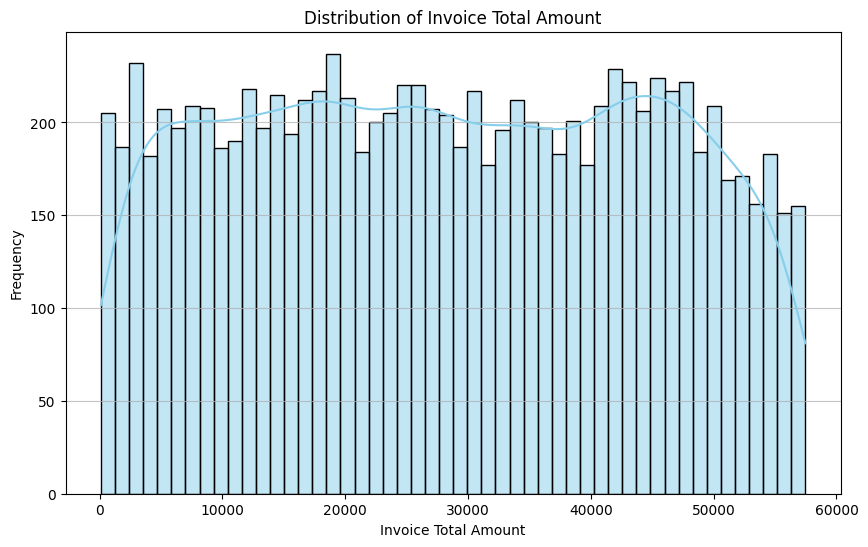

In [24]:
total_amount_pd = df_cleaned.select("InvoiceTotal_amount").toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(total_amount_pd["InvoiceTotal_amount"], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Invoice Total Amount")
plt.xlabel("Invoice Total Amount")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()


/tmp/ipykernel_32459/844658304.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="SellerID", y="sum(InvoiceTotal_amount)", data=top_sellers_pd, palette="viridis")


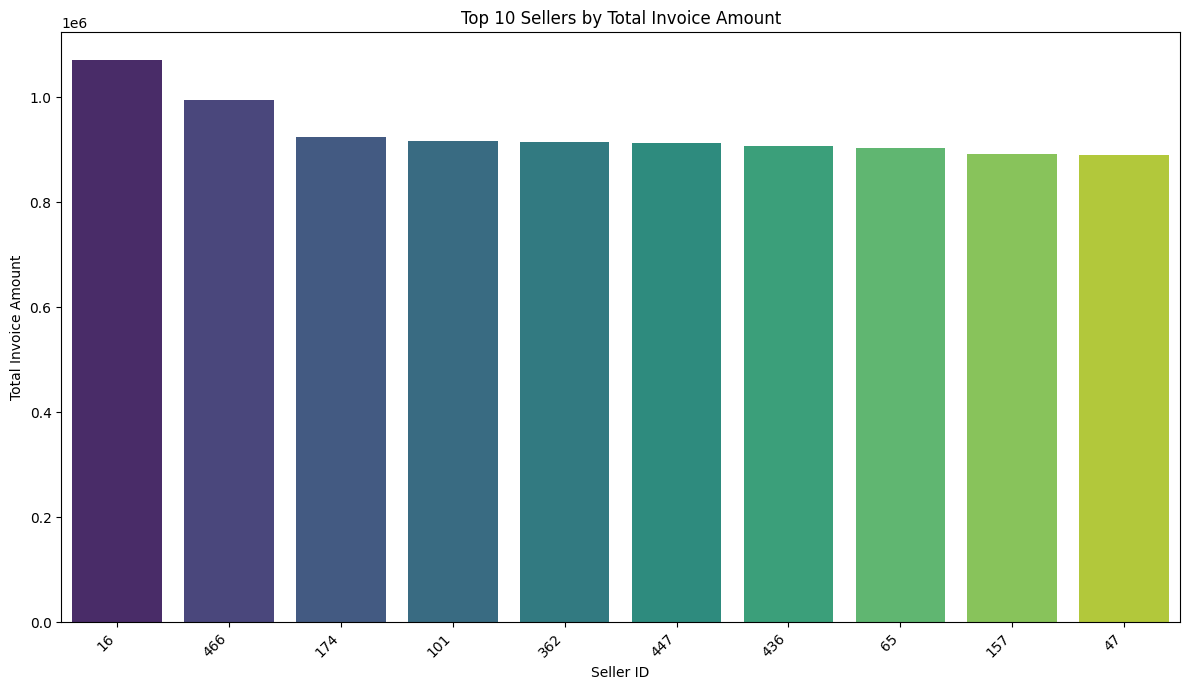

In [26]:
# B. Top Sellers by Total SalesWe can identify the top 10 sellers based on the total sum of their invoices.# Group by SellerID and sum the invoice total, then order by the sum
top_sellers_df = df_cleaned.groupBy("SellerID") \
                           .sum("InvoiceTotal_amount") \
                           .orderBy(col("sum(InvoiceTotal_amount)").desc()) \
                           .limit(10)

# Convert to Pandas for plotting
top_sellers_pd = top_sellers_df.toPandas()

plt.figure(figsize=(12, 7))
sns.barplot(x="SellerID", y="sum(InvoiceTotal_amount)", data=top_sellers_pd, palette="viridis")
plt.title("Top 10 Sellers by Total Invoice Amount")
plt.xlabel("Seller ID")
plt.ylabel("Total Invoice Amount")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# C. Monthly Invoice Trends Over Time
Let's see how the total invoice amount has changed over time by grouping the data by month.# Extract year and month from the invoice_Date


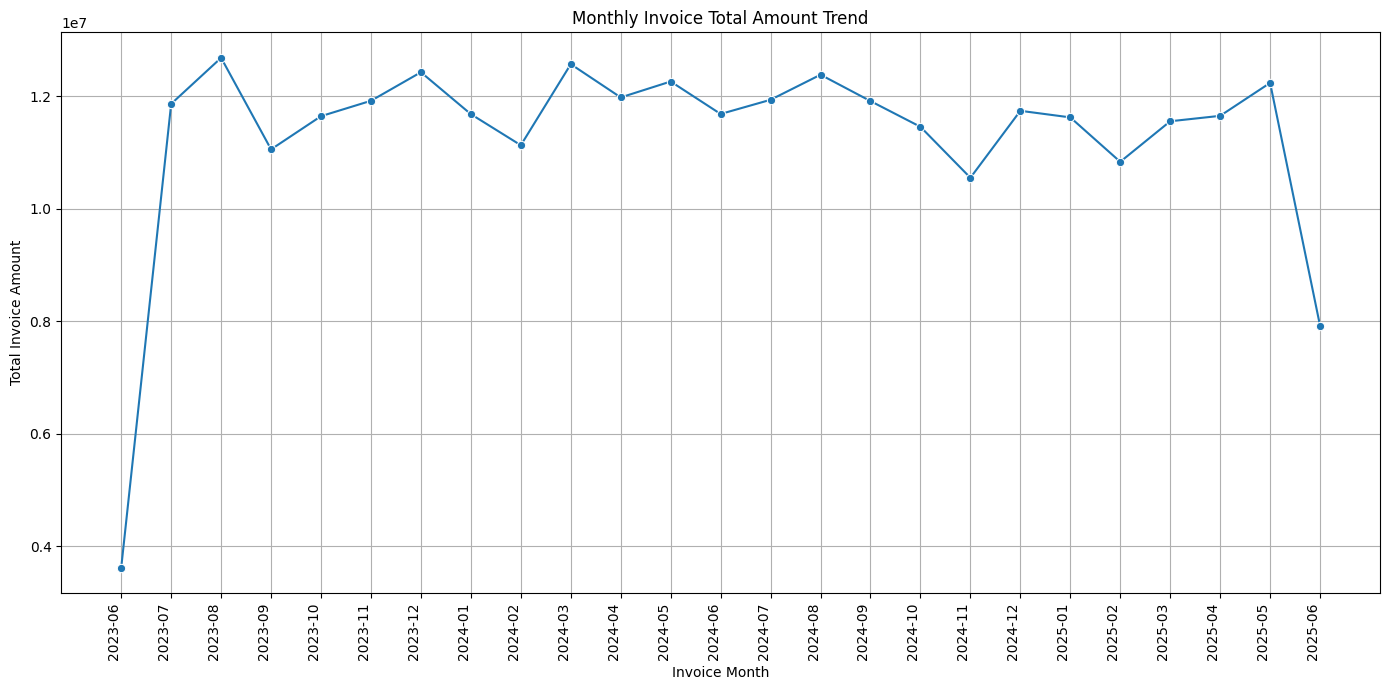

In [27]:
monthly_sales_df = df_cleaned.withColumn("invoice_month", date_format(col("invoice_Date"), "yyyy-MM"))

# Group by month and sum the total amount
monthly_sales_trend = monthly_sales_df.groupBy("invoice_month") \
                                      .sum("InvoiceTotal_amount") \
                                      .orderBy("invoice_month")

# Convert to Pandas for plotting
monthly_sales_trend_pd = monthly_sales_trend.toPandas()

plt.figure(figsize=(14, 7))
sns.lineplot(x="invoice_month", y="sum(InvoiceTotal_amount)", data=monthly_sales_trend_pd, marker='o')
plt.title("Monthly Invoice Total Amount Trend")
plt.xlabel("Invoice Month")
plt.ylabel("Total Invoice Amount")
plt.xticks(rotation=90, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


# D. Popularity of Payment Methods
We can determine which payment methods are most frequently used.# Group by payment method and count the number of invoices


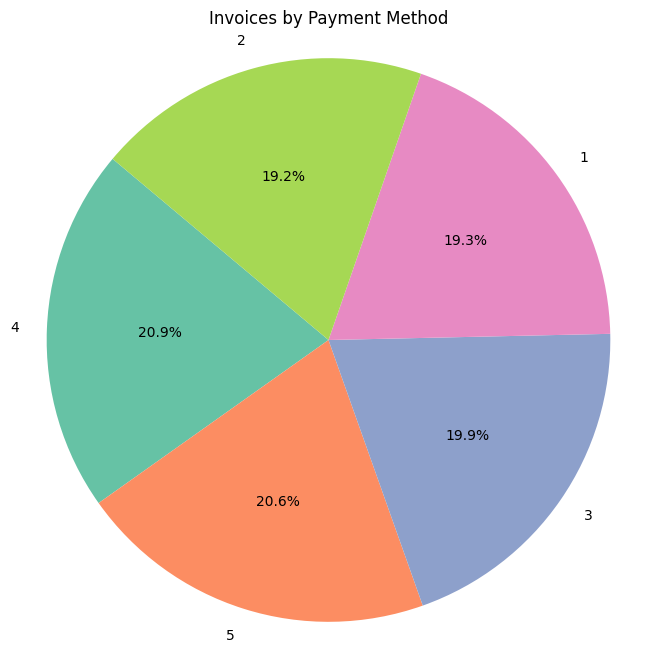

In [28]:
payment_method_counts = df_cleaned.groupBy("Payment_methodID") \
                                .count() \
                                .orderBy(col("count").desc())

# Convert to Pandas for plotting
payment_method_counts_pd = payment_method_counts.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(payment_method_counts_pd["count"], labels=payment_method_counts_pd["Payment_methodID"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.title("Invoices by Payment Method")
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


# E. Relationship between Tax Amount and Subtotal Amount
A scatter plot can show the relationship between tax_amount and subtotal_amount. We would expect to see a strong positive correlation.# Convert necessary columns to Pandas for plotting


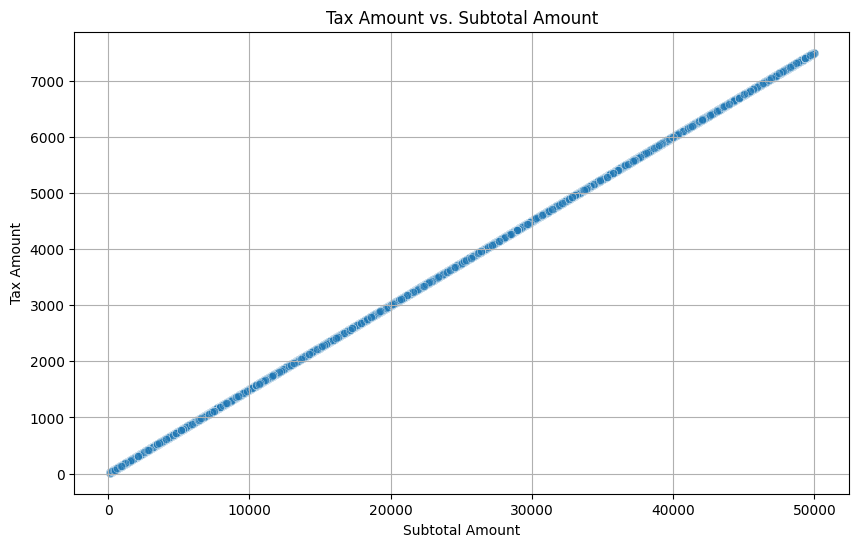

In [29]:
tax_subtotal_pd = df_cleaned.select("tax_amount", "subtotal_amount").toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="subtotal_amount", y="tax_amount", data=tax_subtotal_pd, alpha=0.5)
plt.title("Tax Amount vs. Subtotal Amount")
plt.xlabel("Subtotal Amount")
plt.ylabel("Tax Amount")
plt.grid(True)
plt.show()


# 5. Summary Statistics
Let's get a summary of key numerical fields to understand the central tendency and dispersion of the data.# Describe key numerical columns


In [31]:
summary_stats_df = df_cleaned.select("InvoiceTotal_amount", "subtotal_amount", "tax_amount", "discount_amount").describe()

print("Summary Statistics for Key Numerical Columns:")
summary_stats_df.show()


Summary Statistics for Key Numerical Columns:


25/09/24 12:38:39 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+------------------+-----------------+------------------+
|summary|InvoiceTotal_amount|   subtotal_amount|       tax_amount|   discount_amount|
+-------+-------------------+------------------+-----------------+------------------+
|  count|              10000|             10000|            10000|             10000|
|   mean|  28238.68394300009|25196.184089000028|3779.427487000007| 736.9276330000007|
| stddev| 16274.254453030433|14451.739790704345|2167.760983291342|1650.6653827597447|
|    min|              98.42|            102.34|            15.35|               0.0|
|    max|           57474.01|          49985.91|          7497.89|           9741.03|
+-------+-------------------+------------------+-----------------+------------------+



5. Using Spark SQL for Analysis
Spark SQL provides an alternative way to query and analyze data using SQL syntax. To use it, we first need to create a temporary view of our DataFrame.



In [33]:
# Create a temporary view from the cleaned DataFrame
df_cleaned.createOrReplaceTempView("invoices")

# Run a sample SQL query to inspect the data in the temporary view
spark.sql("SELECT InvoiceID, invoice_Date, InvoiceTotal_amount FROM invoices LIMIT 5").show()



+---------+------------+-------------------+
|InvoiceID|invoice_Date|InvoiceTotal_amount|
+---------+------------+-------------------+
|        1|  2024-02-10|           31921.48|
|        2|  2025-03-15|           46356.01|
|        3|  2023-12-27|           39356.55|
|        4|  2024-09-08|           43654.43|
|        5|  2024-04-25|           49478.49|
+---------+------------+-------------------+



# A. Top Sellers by Total Sales (SQL)
The same analysis for finding the top 10 sellers can be performed with a simple SQL query.

/tmp/ipykernel_32459/3121165217.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="SellerID", y="total_sales", data=top_sellers_sql_pd, palette="viridis")


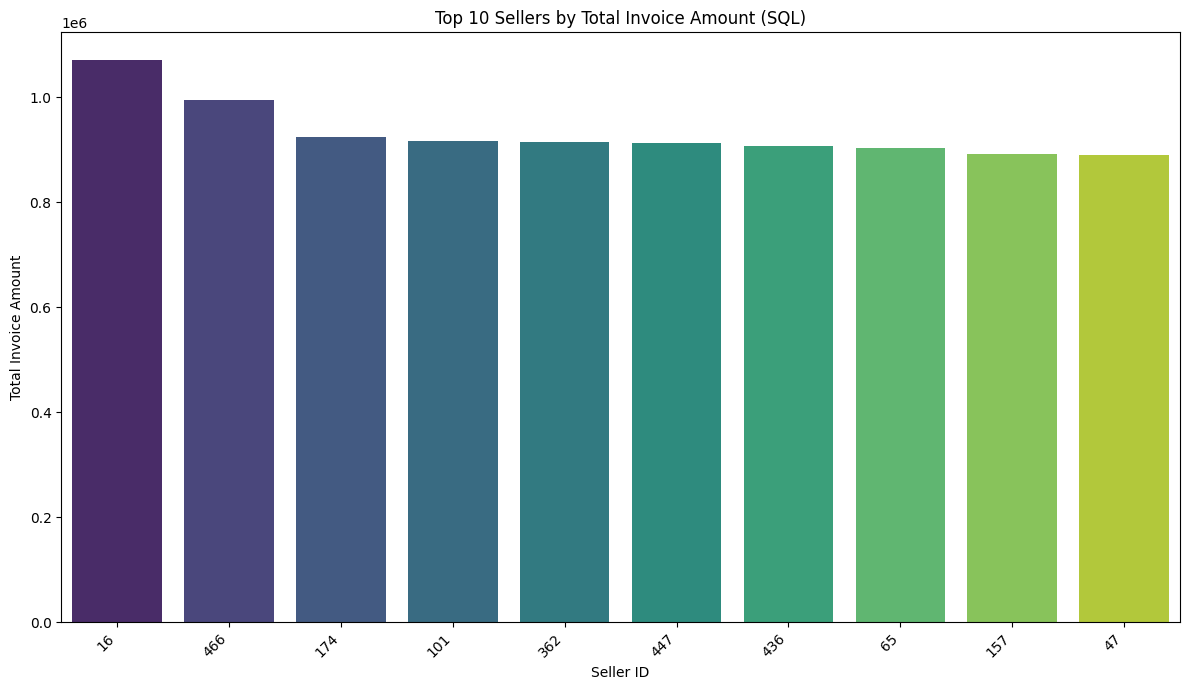

In [34]:

# Execute a SQL query to get the top 10 sellers
top_sellers_sql_df = spark.sql("""
    SELECT 
        SellerID, 
        SUM(InvoiceTotal_amount) AS total_sales
    FROM 
        invoices
    GROUP BY 
        SellerID
    ORDER BY 
        total_sales DESC
    LIMIT 10
""")

# Convert to Pandas for plotting
top_sellers_sql_pd = top_sellers_sql_df.toPandas()

plt.figure(figsize=(12, 7))
sns.barplot(x="SellerID", y="total_sales", data=top_sellers_sql_pd, palette="viridis")
plt.title("Top 10 Sellers by Total Invoice Amount (SQL)")
plt.xlabel("Seller ID")
plt.ylabel("Total Invoice Amount")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()





# B. Monthly Invoice Trends (SQL)
Here is the SQL equivalent for generating the monthly sales trend.


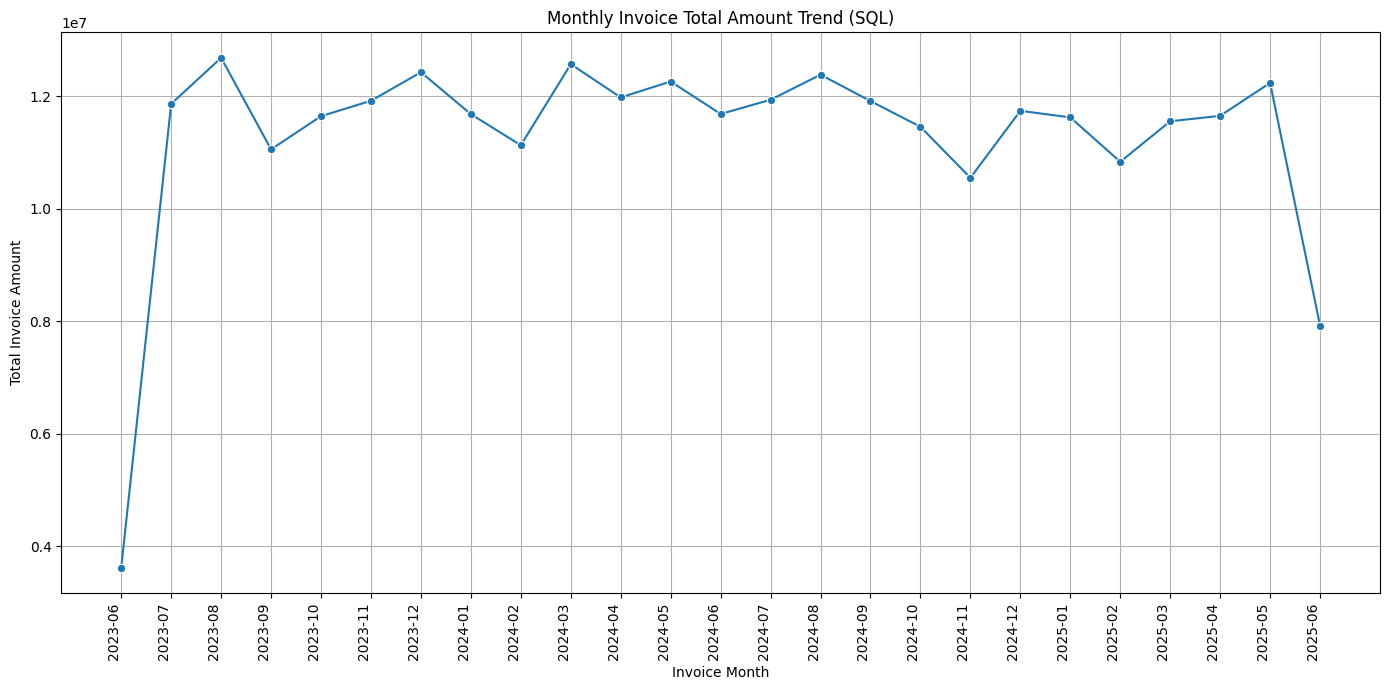

In [35]:

# Execute a SQL query for monthly sales trend
monthly_sales_sql_df = spark.sql("""
    SELECT 
        DATE_FORMAT(invoice_Date, 'yyyy-MM') AS invoice_month, 
        SUM(InvoiceTotal_amount) AS total_amount
    FROM 
        invoices
    GROUP BY 
        invoice_month
    ORDER BY 
        invoice_month
""")

# Convert to Pandas for plotting
monthly_sales_sql_pd = monthly_sales_sql_df.toPandas()

plt.figure(figsize=(14, 7))
sns.lineplot(x="invoice_month", y="total_amount", data=monthly_sales_sql_pd, marker='o')
plt.title("Monthly Invoice Total Amount Trend (SQL)")
plt.xlabel("Invoice Month")
plt.ylabel("Total Invoice Amount")
plt.xticks(rotation=90, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# C. Popularity of Payment Methods (SQL)
You can also find the count of invoices by payment method using Spark SQL.


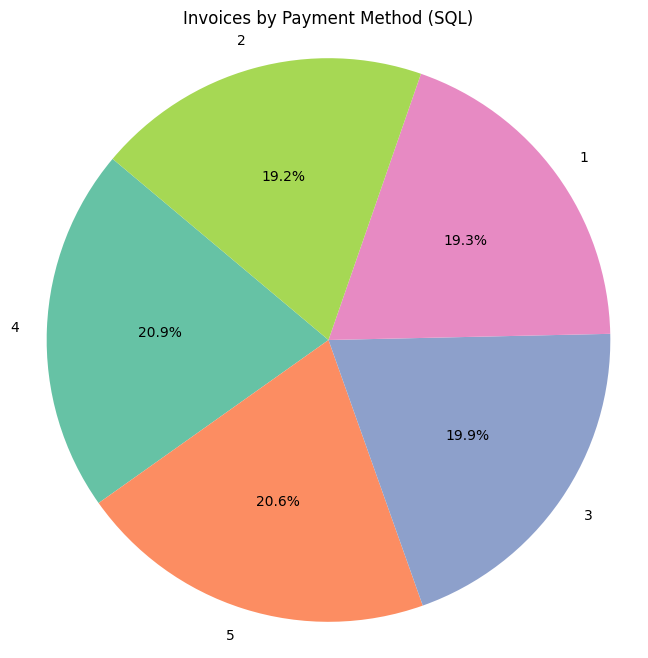

In [36]:


# Execute a SQL query for payment method popularity
payment_method_sql_df = spark.sql("""
    SELECT 
        Payment_methodID, 
        COUNT(*) AS invoice_count
    FROM 
        invoices
    GROUP BY 
        Payment_methodID
    ORDER BY 
        invoice_count DESC
""")

# Convert to Pandas for plotting
payment_method_sql_pd = payment_method_sql_df.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(payment_method_sql_pd["invoice_count"], labels=payment_method_sql_pd["Payment_methodID"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.title("Invoices by Payment Method (SQL)")
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


# D.Popularity of Payment Methods
We can determine which payment methods are most frequently used.


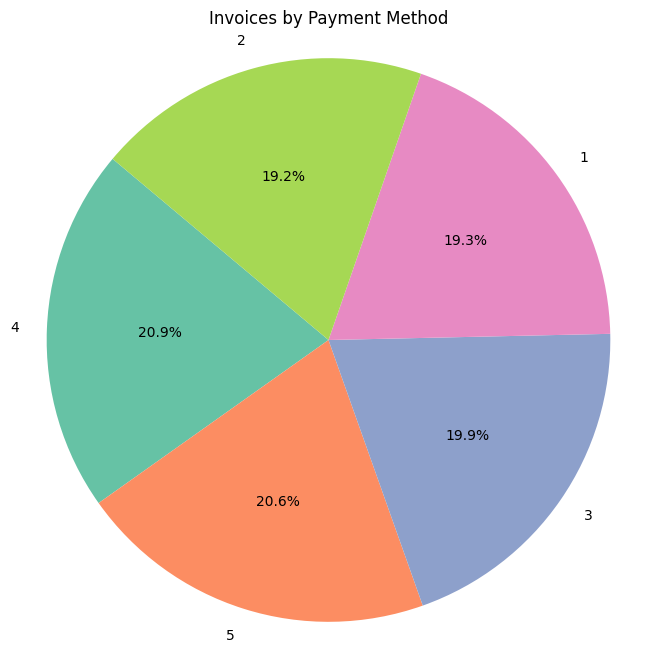

In [38]:

# Group by payment method and count the number of invoices
payment_method_counts = df_cleaned.groupBy("Payment_methodID") \
                                .count() \
                                .orderBy(col("count").desc())

# Convert to Pandas for plotting
payment_method_counts_pd = payment_method_counts.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(payment_method_counts_pd["count"], labels=payment_method_counts_pd["Payment_methodID"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.title("Invoices by Payment Method")
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

#  Invoice Status Analysis (SQL)
This section demonstrates how to use a CASE statement in Spark SQL to infer the status of each invoice. Since the dataset does not contain an explicit "status" column, we will use the invoice_Date and invoice_ModifiedDate columns to approximate the status.

Logic:

Paid: If the invoice_ModifiedDate is not the same as the invoice_Date and is not NULL, we can assume the invoice was modified to reflect a payment.

Overdue: If invoice_Date is older than 30 days from the current date and invoice_ModifiedDate is NULL, we assume it is overdue.

Pending: All other invoices are considered pending.


In [39]:

# Execute a SQL query to categorize invoices by their status
invoice_status_df = spark.sql("""
    SELECT
        COUNT(*) AS total_invoices,
        SUM(CASE WHEN invoice_ModifiedDate IS NOT NULL AND invoice_ModifiedDate != invoice_Date THEN 1 ELSE 0 END) AS paid_invoices,
        SUM(CASE WHEN invoice_ModifiedDate IS NULL AND DATEDIFF(CURRENT_DATE(), invoice_Date) > 30 THEN 1 ELSE 0 END) AS overdue_invoices,
        SUM(CASE WHEN (invoice_ModifiedDate IS NULL AND DATEDIFF(CURRENT_DATE(), invoice_Date) <= 30) OR invoice_Date > CURRENT_DATE() THEN 1 ELSE 0 END) AS pending_invoices
    FROM
        invoices
""")

# Show the results
print("Invoice Status Summary:")
invoice_status_df.show()


Invoice Status Summary:
+--------------+-------------+----------------+----------------+
|total_invoices|paid_invoices|overdue_invoices|pending_invoices|
+--------------+-------------+----------------+----------------+
|         10000|         8963|               0|               0|
+--------------+-------------+----------------+----------------+



# E. Key Financial Metrics (SQL)
This section demonstrates how to calculate key financial metrics using a single Spark SQL query. This provides a quick overview of the dataset's financial health and customer/vendor base.



In [40]:
# Execute a single SQL query to get key financial metrics
financial_metrics_df = spark.sql("""
    SELECT
        SUM(InvoiceTotal_amount) AS total_revenue,
        AVG(InvoiceTotal_amount) AS average_invoice_amount,
        MAX(InvoiceTotal_amount) AS highest_invoice_amount,
        MIN(InvoiceTotal_amount) AS lowest_invoice_amount,
        COUNT(DISTINCT BuyerID) AS unique_customers,
        COUNT(DISTINCT SellerID) AS unique_vendors
    FROM
        invoices
""")

# Show the results
print("Key Financial Metrics:")
financial_metrics_df.show()


Key Financial Metrics:
+-------------------+----------------------+----------------------+---------------------+----------------+--------------+
|      total_revenue|average_invoice_amount|highest_invoice_amount|lowest_invoice_amount|unique_customers|unique_vendors|
+-------------------+----------------------+----------------------+---------------------+----------------+--------------+
|2.823868394300009E8|     28238.68394300009|              57474.01|                98.42|            1980|           500|
+-------------------+----------------------+----------------------+---------------------+----------------+--------------+



# G. Customer Transaction Analysis Report (SQL)
This section focuses on analyzing customer behavior and transaction patterns. We will use Spark SQL to derive insights such as top spenders, average spend, and purchase frequency.
* 1. Top Customers by Total Spend
  This query identifies the top 10 customers based on their total spending.

Top 10 Customers by Total Spend:
+-------+------------------+
|BuyerID|       total_spend|
+-------+------------------+
|   1875|         457195.12|
|   1169|443453.05000000005|
|    547|         420852.97|
|    116|412664.74999999994|
|    384|         397696.98|
|    191|         386951.71|
|   1775|384739.48000000004|
|   1572|         384292.41|
|   1753|373444.19999999995|
|    415|         368398.11|
+-------+------------------+



/tmp/ipykernel_32459/1808604430.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="BuyerID", y="total_spend", data=top_customers_pd, palette="plasma")


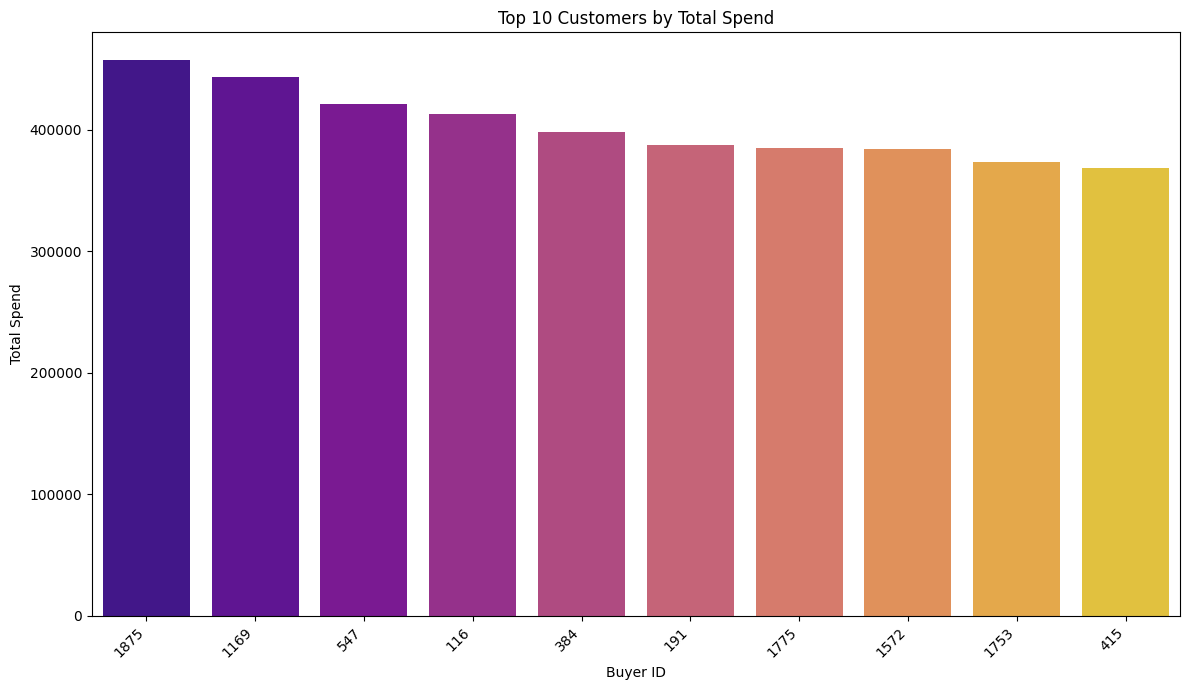

In [43]:



# Execute a SQL query to get the top 10 customers by total spend
top_customers_df = spark.sql("""
    SELECT
        BuyerID,
        SUM(InvoiceTotal_amount) AS total_spend
    FROM
        invoices
    GROUP BY
        BuyerID
    ORDER BY
        total_spend DESC
    LIMIT 10
""")

# Show the results
print("Top 10 Customers by Total Spend:")
top_customers_df.show()

# Convert to Pandas for plotting
top_customers_pd = top_customers_df.toPandas()

plt.figure(figsize=(12, 7))
sns.barplot(x="BuyerID", y="total_spend", data=top_customers_pd, palette="plasma")
plt.title("Top 10 Customers by Total Spend")
plt.xlabel("Buyer ID")
plt.ylabel("Total Spend")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 2. Average Invoice Amount Per Customer
This query calculates the average invoice amount for each customer, which can help in customer segmentation.


In [44]:


# Execute a SQL query to get the average invoice amount per customer
avg_invoice_per_customer_df = spark.sql("""
    SELECT
        BuyerID,
        AVG(InvoiceTotal_amount) AS avg_invoice_amount
    FROM
        invoices
    GROUP BY
        BuyerID
    ORDER BY
        avg_invoice_amount DESC
""")

# Show the results for the top 10 customers by average invoice amount
print("Top 10 Customers by Average Invoice Amount:")
avg_invoice_per_customer_df.show(10)


Top 10 Customers by Average Invoice Amount:
+-------+------------------+
|BuyerID|avg_invoice_amount|
+-------+------------------+
|   1879|          56097.54|
|   1756|55679.255000000005|
|    333|          55534.01|
|   1372|54873.774999999994|
|   1913|          52251.97|
|   1031| 52191.92999999999|
|    760|52019.378000000004|
|    439|51790.613333333335|
|    852|          50965.96|
|   1239|           50809.0|
+-------+------------------+
only showing top 10 rows


# 3. Purchase Frequency (New vs. Repeat Customers)
This analysis categorizes customers into "New" (one purchase) and "Repeat" (multiple purchases) to understand customer loyalty.



In [45]:

# Execute a SQL query to categorize customers by purchase frequency
purchase_frequency_df = spark.sql("""
    SELECT
        CASE
            WHEN num_invoices = 1 THEN 'New Customer (1 purchase)'
            ELSE 'Repeat Customer (>1 purchase)'
        END AS customer_type,
        COUNT(*) AS customer_count
    FROM (
        SELECT
            BuyerID,
            COUNT(InvoiceID) AS num_invoices
        FROM
            invoices
        GROUP BY
            BuyerID
    ) AS subquery
    GROUP BY
        customer_type
""")

# Show the results
print("Customer Purchase Frequency:")
purchase_frequency_df.show()


Customer Purchase Frequency:
+--------------------+--------------+
|       customer_type|customer_count|
+--------------------+--------------+
|Repeat Customer (...|          1910|
|New Customer (1 p...|            70|
+--------------------+--------------+



# 4. Payment Trends (On-time vs. Delayed Payments)
This query analyzes the payment duration to identify on-time versus delayed payments. We use a threshold of 30 days to classify payments.


Payment Trends:
+--------------+-----------------+
|payment_status|transaction_count|
+--------------+-----------------+
|       On-time|             1510|
|       Delayed|             7453|
+--------------+-----------------+



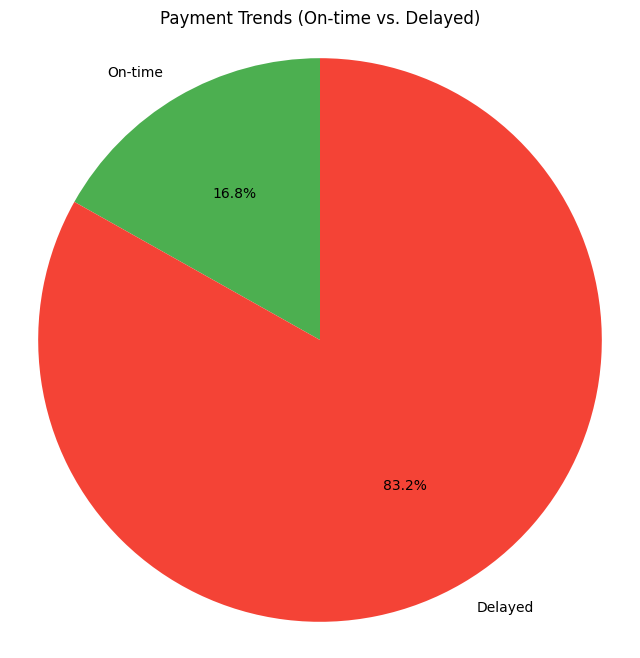

In [46]:


# Execute a SQL query to analyze payment trends
payment_trends_df = spark.sql("""
    SELECT
        CASE
            WHEN DATEDIFF(invoice_ModifiedDate, invoice_Date) <= 30 THEN 'On-time'
            WHEN DATEDIFF(invoice_ModifiedDate, invoice_Date) > 30 THEN 'Delayed'
            ELSE 'Not Applicable' -- Invoices without a modified date
        END AS payment_status,
        COUNT(*) AS transaction_count
    FROM
        invoices
    WHERE invoice_ModifiedDate IS NOT NULL AND invoice_ModifiedDate != invoice_Date
    GROUP BY
        payment_status
""")

# Show the results
print("Payment Trends:")
payment_trends_df.show()

# Convert to Pandas for plotting
payment_trends_pd = payment_trends_df.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(payment_trends_pd["transaction_count"], labels=payment_trends_pd["payment_status"], autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#F44336', 'lightgray'])
plt.title("Payment Trends (On-time vs. Delayed)")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# F Key Financial Metrics (SQL)
This section demonstrates how to calculate key financial metrics using a single Spark SQL query. This provides a quick overview of the dataset's financial health and customer/vendor base.



In [41]:
# Execute a single SQL query to get key financial metrics
financial_metrics_df = spark.sql("""
    SELECT
        SUM(InvoiceTotal_amount) AS total_revenue,
        AVG(InvoiceTotal_amount) AS average_invoice_amount,
        MAX(InvoiceTotal_amount) AS highest_invoice_amount,
        MIN(InvoiceTotal_amount) AS lowest_invoice_amount,
        COUNT(DISTINCT BuyerID) AS unique_customers,
        COUNT(DISTINCT SellerID) AS unique_vendors
    FROM
        invoices
""")

# Show the results
print("Key Financial Metrics:")
financial_metrics_df.show()


Key Financial Metrics:
+-------------------+----------------------+----------------------+---------------------+----------------+--------------+
|      total_revenue|average_invoice_amount|highest_invoice_amount|lowest_invoice_amount|unique_customers|unique_vendors|
+-------------------+----------------------+----------------------+---------------------+----------------+--------------+
|2.823868394300009E8|     28238.68394300009|              57474.01|                98.42|            1980|           500|
+-------------------+----------------------+----------------------+---------------------+----------------+--------------+



# H. Vendor and Financial Health Analysis Report (SQL)
This section provides a deeper look into vendor performance and financial health metrics, including payment efficiency and discrepancies.

# 1. Top Vendors by Invoice Volume
This query identifies the top 10 vendors based on the number of invoices they've issued.

Top 10 Vendors by Invoice Volume:
+--------+-------------+
|SellerID|invoice_count|
+--------+-------------+
|     101|           34|
|     466|           32|
|     447|           31|
|      84|           31|
|     494|           31|
|     323|           30|
|     419|           30|
|     352|           30|
|     279|           30|
|      16|           30|
+--------+-------------+



/tmp/ipykernel_32459/4020645247.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="SellerID", y="invoice_count", data=top_vendors_pd, palette="cividis")


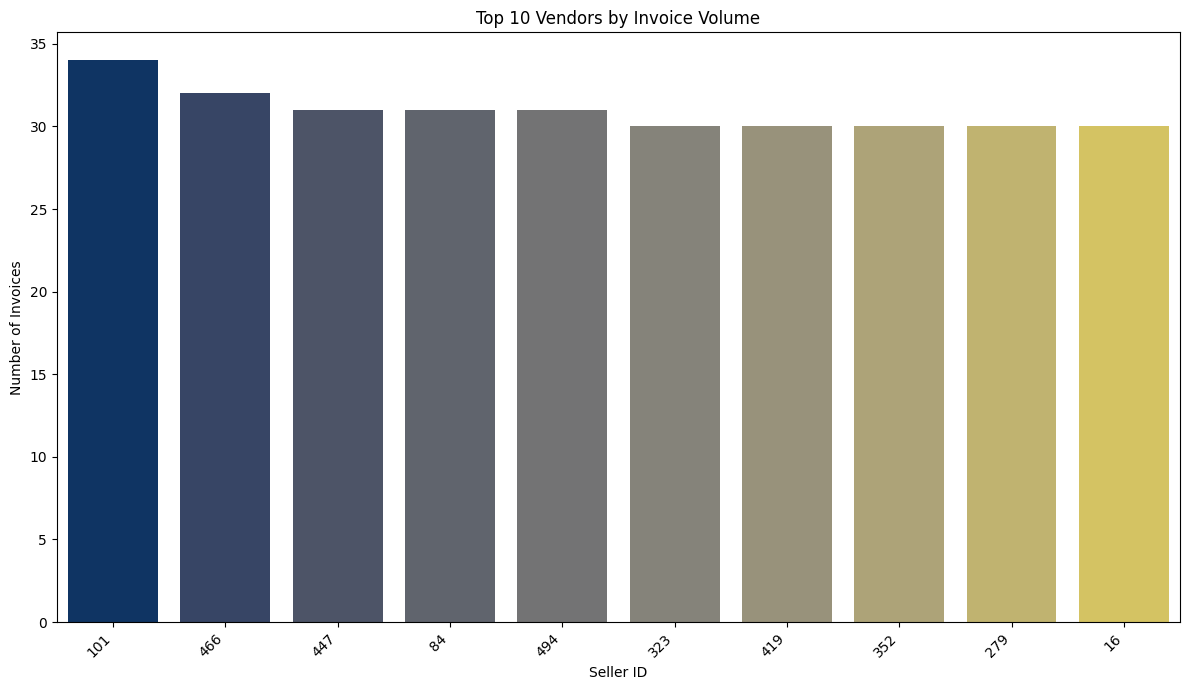

In [47]:
# Execute a SQL query to get the top 10 vendors by invoice volume
top_vendors_df = spark.sql("""
    SELECT
        SellerID,
        COUNT(InvoiceID) AS invoice_count
    FROM
        invoices
    GROUP BY
        SellerID
    ORDER BY
        invoice_count DESC
    LIMIT 10
""")

# Show the results
print("Top 10 Vendors by Invoice Volume:")
top_vendors_df.show()

# Convert to Pandas for plotting
top_vendors_pd = top_vendors_df.toPandas()

plt.figure(figsize=(12, 7))
sns.barplot(x="SellerID", y="invoice_count", data=top_vendors_pd, palette="cividis")
plt.title("Top 10 Vendors by Invoice Volume")
plt.xlabel("Seller ID")
plt.ylabel("Number of Invoices")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Average Payment Processing Time
This query calculates the average number of days it takes for an invoice to be paid (based on the difference between the invoice and modified dates).


In [48]:

# Execute a SQL query to calculate average payment processing time
avg_processing_time_df = spark.sql("""
    SELECT
        AVG(DATEDIFF(invoice_ModifiedDate, invoice_Date)) AS avg_processing_days
    FROM
        invoices
    WHERE
        invoice_ModifiedDate IS NOT NULL AND invoice_ModifiedDate != invoice_Date
""")

# Show the results
print("Average Payment Processing Time:")
avg_processing_time_df.show()

Average Payment Processing Time:
+-------------------+
|avg_processing_days|
+-------------------+
| 184.31038714716055|
+-------------------+



# 3. Discrepancies (Discounts, Cancellations, Errors)
This query aggregates and categorizes various invoice discrepancies, such as discounts, cancellations, and errors.

Invoice Discrepancies Summary:
+-----------------------+------------------+--------------------+
|invoices_with_discounts|cancelled_invoices|invoices_with_errors|
+-----------------------+------------------+--------------------+
|                   2971|              9524|                9821|
+-----------------------+------------------+--------------------+



/tmp/ipykernel_32459/2310358459.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette="Spectral")


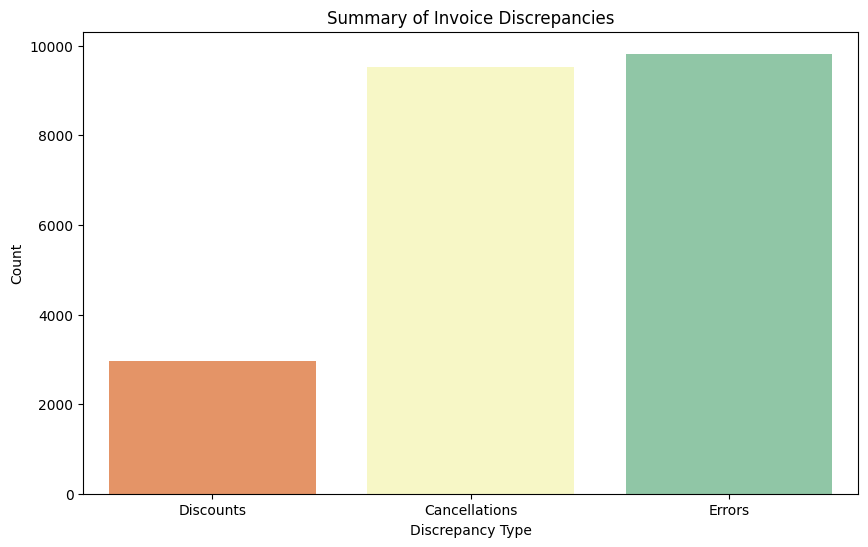

4

In [50]:
# Execute a SQL query to summarize discrepancies
discrepancies_df = spark.sql("""
    SELECT
        SUM(CASE WHEN discount_amount > 0 THEN 1 ELSE 0 END) AS invoices_with_discounts,
        SUM(CASE WHEN CancelReasonID IS NOT NULL AND CancelReasonID != 0 THEN 1 ELSE 0 END) AS cancelled_invoices,
        SUM(CASE WHEN ErrorTypeID IS NOT NULL AND ErrorTypeID != 0 THEN 1 ELSE 0 END) AS invoices_with_errors
    FROM
        invoices
""")

# Show the results
print("Invoice Discrepancies Summary:")
discrepancies_df.show()

# Convert the summary to a Pandas DataFrame for plotting
discrepancies_pd = discrepancies_df.toPandas().iloc[0]

# Define the data for the bar chart
labels = ['Discounts', 'Cancellations', 'Errors']
counts = [discrepancies_pd['invoices_with_discounts'], discrepancies_pd['cancelled_invoices'], discrepancies_pd['invoices_with_errors']]

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=counts, palette="Spectral")
plt.title("Summary of Invoice Discrepancies")
plt.xlabel("Discrepancy Type")
plt.ylabel("Count")
plt.show()

4

# 4 Vendor Payment Terms Compliance
This query analyzes the number of days between invoice and payment dates to determine vendor compliance with payment terms (assuming a 30-day term).

Vendor Payment Terms Compliance:
+-------------------------+-------------+
|payment_compliance_status|invoice_count|
+-------------------------+-------------+
|             Over 30 Days|         7453|
|           Within 30 Days|         1510|
+-------------------------+-------------+



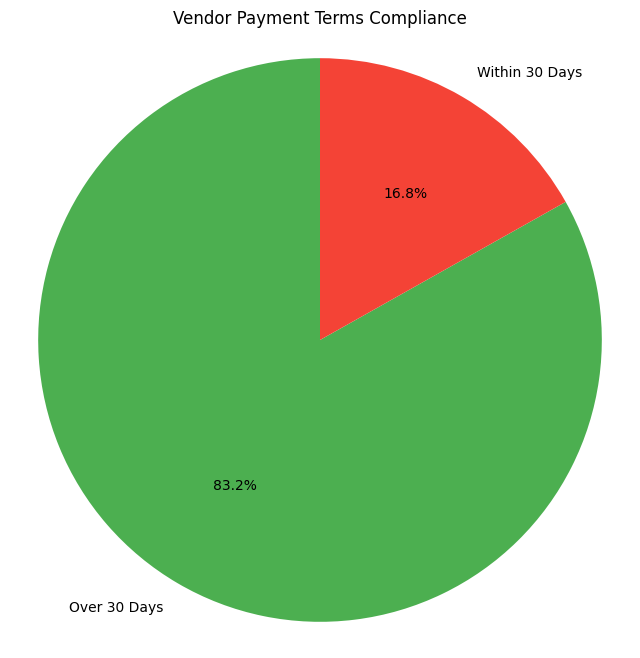

In [51]:
# Execute a SQL query to analyze vendor payment terms compliance
vendor_compliance_df = spark.sql("""
    SELECT
        CASE
            WHEN DATEDIFF(invoice_ModifiedDate, invoice_Date) <= 30 THEN 'Within 30 Days'
            ELSE 'Over 30 Days'
        END AS payment_compliance_status,
        COUNT(*) AS invoice_count
    FROM
        invoices
    WHERE
        invoice_ModifiedDate IS NOT NULL AND invoice_ModifiedDate != invoice_Date
    GROUP BY
        payment_compliance_status
    ORDER BY
        invoice_count DESC
""")

# Show the results
print("Vendor Payment Terms Compliance:")
vendor_compliance_df.show()

# Convert to Pandas for plotting
vendor_compliance_pd = vendor_compliance_df.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(vendor_compliance_pd["invoice_count"], labels=vendor_compliance_pd["payment_compliance_status"], autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#F44336'])
plt.title("Vendor Payment Terms Compliance")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# I. Revenue Growth and Sales Trends Analysis (SQL)
This section provides a deeper analysis of revenue performance, including growth rates and seasonal patterns, which is critical for business planning and forecasting.

# 1. Monthly Revenue Growth
This query calculates the month-over-month revenue growth percentage. It uses a window function (LAG) to compare the current month's total sales with the previous month's.

In [55]:
# Execute a SQL query to calculate monthly revenue and growth
monthly_revenue_growth_df = spark.sql("""
    WITH MonthlySales AS (
        SELECT
            DATE_FORMAT(invoice_Date, 'yyyy-MM') AS invoice_month,
            SUM(InvoiceTotal_amount) AS total_monthly_sales
        FROM
            invoices
        GROUP BY
            invoice_month
    ),
    LaggedSales AS (
        SELECT
            invoice_month,
            total_monthly_sales,
            LAG(total_monthly_sales, 1, 0) OVER (ORDER BY invoice_month) AS previous_monthly_sales
        FROM
            MonthlySales
    )
    SELECT
        invoice_month,
        total_monthly_sales,
        previous_monthly_sales,
        (total_monthly_sales - previous_monthly_sales) / previous_monthly_sales * 100 AS growth_percentage
    FROM
        LaggedSales
    ORDER BY
        invoice_month
""")

# Show the results
print("Monthly Revenue Growth:")
monthly_revenue_growth_df.show()

# Convert to Pandas for plotting
monthly_growth_pd = monthly_revenue_growth_df.toPandas()

plt.figure(figsize=(14, 7))
sns.lineplot(x="invoice_month", y="growth_percentage", data=monthly_growth_pd, marker='o', color='purple')
plt.title("Monthly Revenue Growth (%)")
plt.xlabel("Invoice Month")
plt.ylabel("Growth Percentage (%)")
plt.xticks(rotation=90, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

Monthly Revenue Growth:


25/09/24 13:40:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/24 13:40:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/24 13:40:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/24 13:40:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/24 13:40:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/24 13:40:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/24 1

ArithmeticException: [DIVIDE_BY_ZERO] Division by zero. Use `try_divide` to tolerate divisor being 0 and return NULL instead. If necessary set "spark.sql.ansi.enabled" to "false" to bypass this error. SQLSTATE: 22012
== SQL (line 23, position 9) ==
        (total_monthly_sales - previous_monthly_sales) / previous_monthly_sales * 100 AS growth_percentage
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


# 2. Quarterly Revenue Growth
Similar to monthly growth, this query calculates the quarter-over-quarter revenue growth.

In [57]:
# Execute a SQL query to calculate quarterly revenue and growth
quarterly_revenue_growth_df = spark.sql("""
    WITH QuarterlySales AS (
        SELECT
            CONCAT(YEAR(invoice_Date), '-', QUARTER(invoice_Date)) AS invoice_quarter,
            SUM(InvoiceTotal_amount) AS total_quarterly_sales
        FROM
            invoices
        GROUP BY
            invoice_quarter
    ),
    LaggedSales AS (
        SELECT
            invoice_quarter,
            total_quarterly_sales,
            LAG(total_quarterly_sales, 1, 0) OVER (ORDER BY invoice_quarter) AS previous_quarterly_sales
        FROM
            QuarterlySales
    )
    SELECT
        invoice_quarter,
        total_quarterly_sales,
        previous_quarterly_sales,
        (total_quarterly_sales - previous_quarterly_sales) / previous_quarterly_sales * 100 AS growth_percentage
    FROM
        LaggedSales
    ORDER BY
        invoice_quarter
""")

# Show the results
print("Quarterly Revenue Growth:")
quarterly_revenue_growth_df.show()

# Convert to Pandas for plotting
quarterly_growth_pd = quarterly_revenue_growth_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="invoice_quarter", y="growth_percentage", data=quarterly_growth_pd, palette="pastel")
plt.title("Quarterly Revenue Growth (%)")
plt.xlabel("Invoice Quarter")
plt.ylabel("Growth Percentage (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Quarterly Revenue Growth:


25/09/24 13:41:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/24 13:41:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/24 13:41:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/24 13:41:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/24 13:41:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/24 13:41:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/24 1

ArithmeticException: [DIVIDE_BY_ZERO] Division by zero. Use `try_divide` to tolerate divisor being 0 and return NULL instead. If necessary set "spark.sql.ansi.enabled" to "false" to bypass this error. SQLSTATE: 22012
== SQL (line 23, position 9) ==
        (total_quarterly_sales - previous_quarterly_sales) / previous_quarterly_sales * 100 AS growth_percentage
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


# 3. Seasonal Trends in Sales
This analysis aggregates the total sales for each month of the year across all years, revealing potential seasonal patterns.

Seasonal Sales Trends by Month:
+-------------+--------------------+
|month_of_year|         total_sales|
+-------------+--------------------+
|            1|2.3310756070000008E7|
|            2|2.1968049760000005E7|
|            3|2.4131211059999973E7|
|            4|2.3636080289999984E7|
|            5| 2.450533139999997E7|
|            6|2.3225823300000034E7|
|            7| 2.380713108000002E7|
|            8|2.5071977340000033E7|
|            9|2.2974455060000006E7|
|           10| 2.310742256999998E7|
|           11|2.2474777319999993E7|
|           12| 2.417382417999999E7|
+-------------+--------------------+



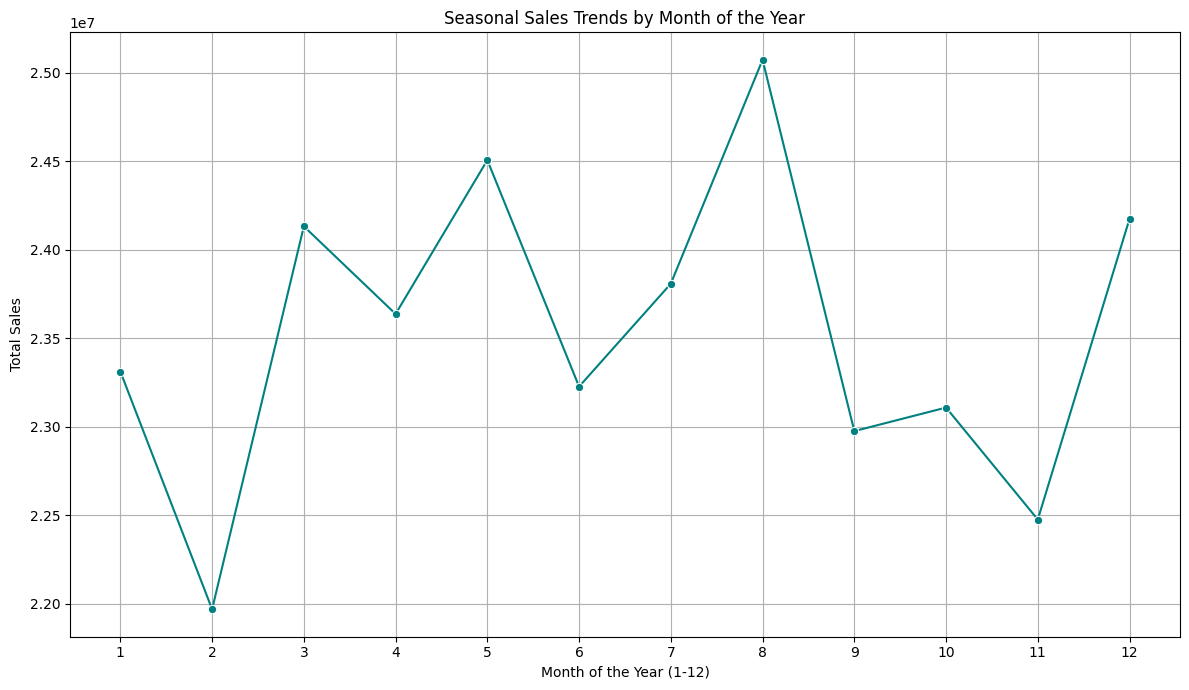

In [59]:
# Execute a SQL query to get seasonal sales trends by month of the year
seasonal_trends_df = spark.sql("""
    SELECT
        MONTH(invoice_Date) AS month_of_year,
        SUM(InvoiceTotal_amount) AS total_sales
    FROM
        invoices
    GROUP BY
        month_of_year
    ORDER BY
        month_of_year
""")

# Show the results
print("Seasonal Sales Trends by Month:")
seasonal_trends_df.show()

# Convert to Pandas for plotting
seasonal_trends_pd = seasonal_trends_df.toPandas()

plt.figure(figsize=(12, 7))
sns.lineplot(x="month_of_year", y="total_sales", data=seasonal_trends_pd, marker='o', color='teal')
plt.title("Seasonal Sales Trends by Month of the Year")
plt.xlabel("Month of the Year (1-12)")
plt.ylabel("Total Sales")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Summary Statistics
Let's get a summary of key numerical fields to understand the central tendency and dispersion of the data.


In [37]:



# Describe key numerical columns
summary_stats_df = df_cleaned.select("InvoiceTotal_amount", "subtotal_amount", "tax_amount", "discount_amount").describe()

print("Summary Statistics for Key Numerical Columns:")
summary_stats_df.show()





Summary Statistics for Key Numerical Columns:
+-------+-------------------+------------------+-----------------+------------------+
|summary|InvoiceTotal_amount|   subtotal_amount|       tax_amount|   discount_amount|
+-------+-------------------+------------------+-----------------+------------------+
|  count|              10000|             10000|            10000|             10000|
|   mean|  28238.68394300009|25196.184089000028|3779.427487000007| 736.9276330000007|
| stddev| 16274.254453030433|14451.739790704345|2167.760983291342|1650.6653827597447|
|    min|              98.42|            102.34|            15.35|               0.0|
|    max|           57474.01|          49985.91|          7497.89|           9741.03|
+-------+-------------------+------------------+-----------------+------------------+



In [ ]:
# 6. Stop Spark SessionFinally, stop the Spark session to free up resources.spark.stop()
print("Spark Session stopped.")
